### Imports

In [43]:
%load_ext autoreload
%autoreload 2

from jaxflows.flows import NeuralSplineFlow
from jaxflows.train_utils import train_flow
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as onp
from jax import random
from rnpe.denoise import horseshoe_denoiser_model
from numpyro.infer import MCMC, NUTS
import jax
import seaborn as sns
from rnpe.plot_utils import pairplot


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load dataset

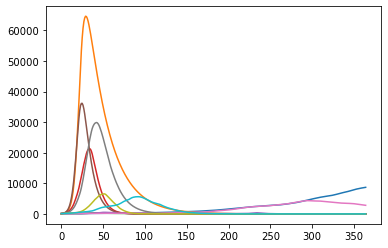

In [44]:
simulations = jnp.load("data/sirsde/simulations.npz")
theta = simulations["theta"]
theta = jnp.array(theta)
x = simulations["x"]
x = jnp.array(x)
plt.plot(jnp.transpose(x[:10]))
plt.show()

### Create misspecification

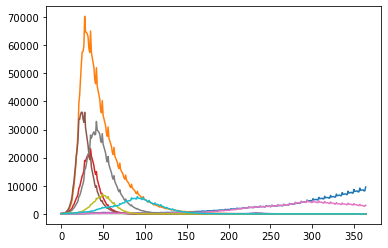

In [45]:
def get_day_idx(days: list):
    weekdays = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
    weekdays = {day: i for i, day in enumerate(weekdays)}
    idxs = []
    for day in days:
        idxs += list(range(weekdays[day], 365, 7))
    return sorted(idxs)

def misspecify(x, multiplier=0.95):
    x = onp.array(x)
    x = x.copy()
    days = ["saturday", "sunday", "monday"]
    sat_idx, sun_idx, mon_idx = [get_day_idx([d]) for d in days]
    mon_idx = mon_idx[1:]
    sat_new = x[:, sat_idx] * multiplier
    sun_new = x[:, sun_idx] * multiplier
    missed_cases = (x[:, sat_idx] - sat_new) + (x[:, sun_idx] - sun_new)
    mon_new = x[:, mon_idx] + missed_cases

    for idx, new in zip([sat_idx, sun_idx, mon_idx], [sat_new, sun_new, mon_new]):
        x[:, idx] = new
    return jnp.array(x)

x_misspecified = misspecify(x)
plt.plot(jnp.transpose(x_misspecified[:10]))
plt.show()

### Calculate summary statistics

In [57]:
@jax.jit
@jax.vmap
def autocorr_lag1(x):
    x1 = x[:-1]
    x2 = x[1:]
    x1_dif = x1 - x1.mean()
    x2_dif = x2 - x2.mean()
    numerator = (x1_dif*x2_dif).sum()
    denominator = jnp.sqrt((x1_dif**2).sum()*(x2_dif**2).sum())
    return numerator/denominator

def cumulative_day(x, q):
    "Day when q proportion of total infections was reached."
    prop_i = (jnp.cumsum(x, axis=1).T/jnp.sum(x, axis=1)).T
    return jnp.argmax(prop_i > q, axis=1)


def summarise(x):

    summaries = {
        "mean" : jnp.log(x.mean(axis=1)),
        "median" : jnp.log(jnp.median(x, axis=1)),
        "max_infections" : jnp.log(jnp.argmax(x, axis=1) + 1),  # +1 incase 0 is max_day
        "max_infections_day" : jnp.log(jnp.max(x, axis=1)),
        #"quater_total_reached_at": jnp.log(cumulative_day(x, 0.25)),
        "half_total_reached_at": jnp.log(cumulative_day(x, 0.5)),
        #"three_quater_total_reached_at": jnp.log(cumulative_day(x, 0.75)),
        "autocor_lag1" : autocorr_lag1(x),
    }
    
    names = list(summaries.keys())
    summaries = jnp.column_stack(list(summaries.values()))
    return summaries, names 

In [59]:
s, s_names = summarise(x)
s_misspecified, _ = summarise(x_misspecified)

In [60]:
s_means, s_stds = s.mean(axis=0), s.std(axis=0)
s = (s-s_means)/s_stds

s_misspecified = (s_misspecified-s_means)/s_stds

### Train marginal likelihood flow

In [61]:
key, flow_key, train_key = random.split(random.PRNGKey(0), 3)
flow = NeuralSplineFlow(flow_key, target_dim=s.shape[1])
flow, losses = train_flow(train_key, flow, s, max_epochs=30)

100%|██████████| 30/30 [02:17<00:00,  4.58s/it, train=-3.73, val=-3.69]


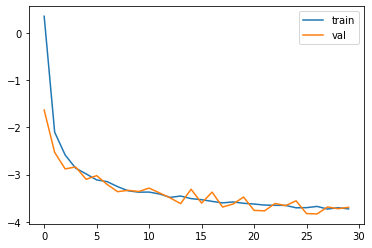

In [63]:
for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend()

### Denoise with MCMC

In [64]:
from numpyro.infer import NUTS
from rnpe.denoise import horseshoe_denoiser_model

obs_num = 0
y_obs = s_misspecified[obs_num]
theta_true = theta[obs_num]

kernel = NUTS(horseshoe_denoiser_model, target_accept_prob=0.95) # Smaller step because of peaky distribution
mcmc = MCMC(kernel, num_warmup=10000, num_samples=10000)
key, mcmc_key = random.split(key)
mcmc.run(mcmc_key, y_obs, flow.bijection.inverse, tau_prior_scale=0.1, min_scale=0.05)  # min scale improves mixing at cost of reducing shrinkage
mcmc.print_summary()


sample: 100%|██████████| 20000/20000 [01:29<00:00, 222.74it/s, 127 steps of size 3.36e-02. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
lambdas[0]      1.57      4.14      0.76      0.00      3.29   6570.63      1.00
lambdas[1]      1.08      2.21      0.55      0.00      2.29   7440.49      1.00
lambdas[2]      1.25      3.93      0.60      0.00      2.59   6783.37      1.00
lambdas[3]      1.68      4.03      0.81      0.00      3.55   6573.00      1.00
lambdas[4]      1.04      1.84      0.56      0.00      2.28   7971.80      1.00
lambdas[5]    124.17    351.95     46.95      0.03    242.05   3713.28      1.00
       tau      0.10      0.11      0.06      0.00      0.20   4702.08      1.00
      z[0]     -0.23      0.57     -0.21     -1.00      0.63   1009.16      1.01
      z[1]     -1.47      0.43     -1.53     -2.05     -0.88   1440.16      1.00
      z[2]      2.13      0.50      2.13      1.48      2.92    965.37      1.00
      z[3]      0.20      0.92      0.18     -1.26      1.72   5978.81      1.00
      z[4]      0.86      0

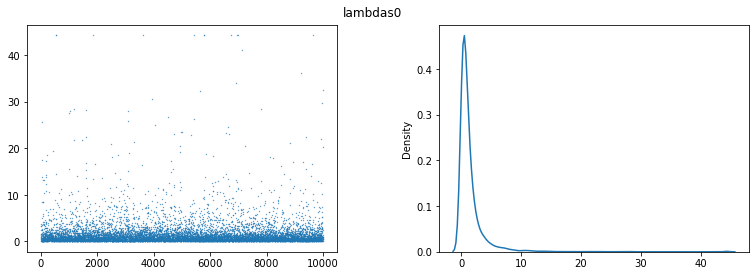

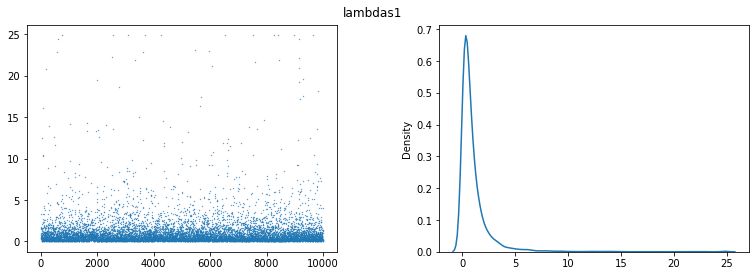

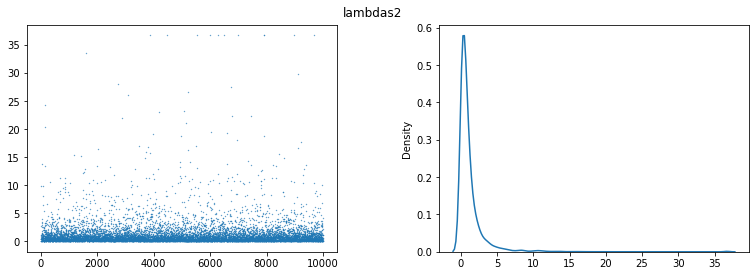

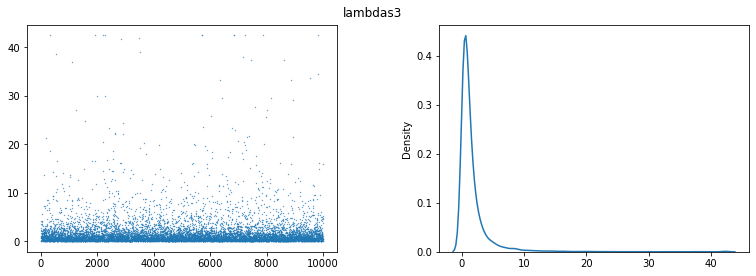

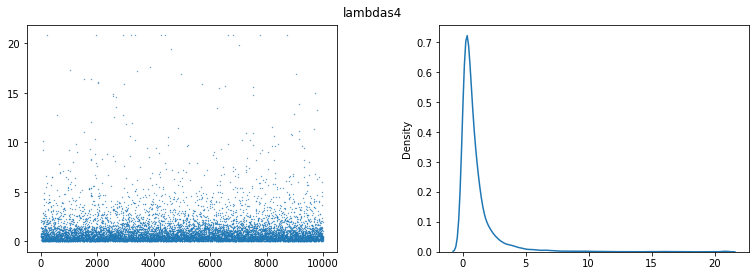

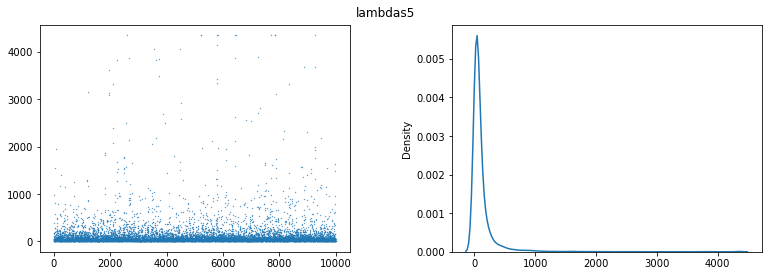

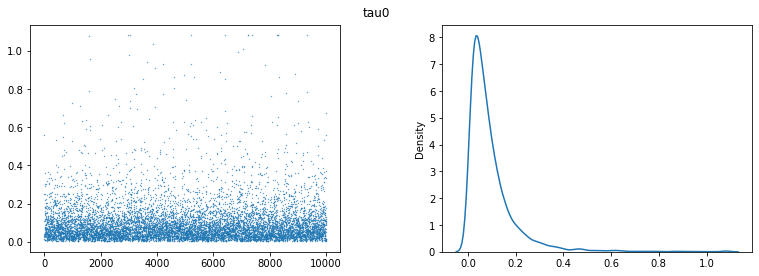

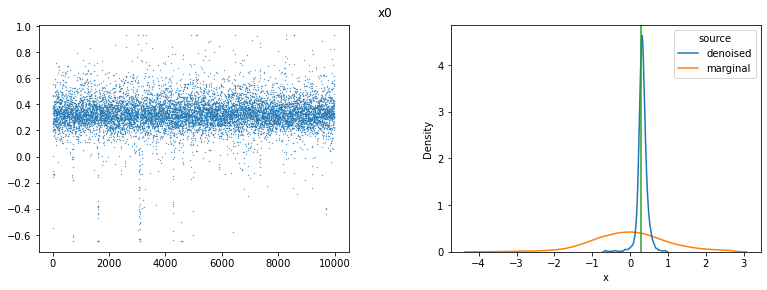

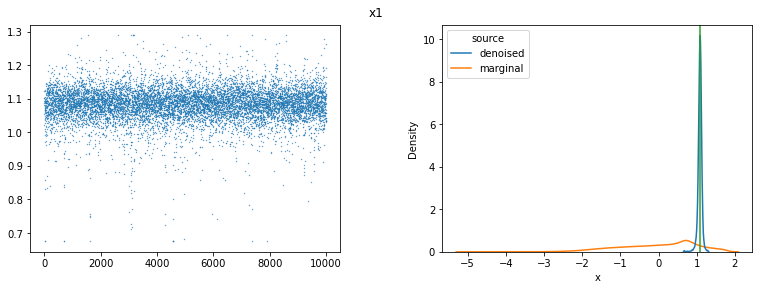

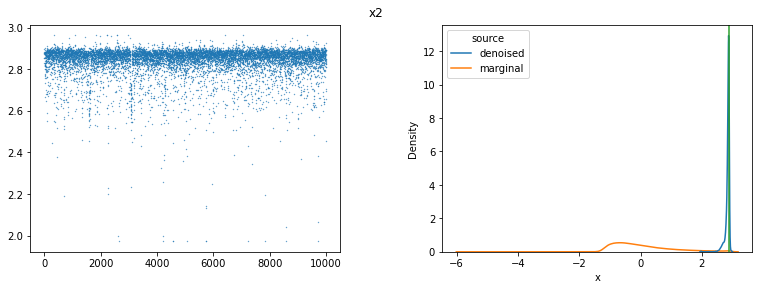

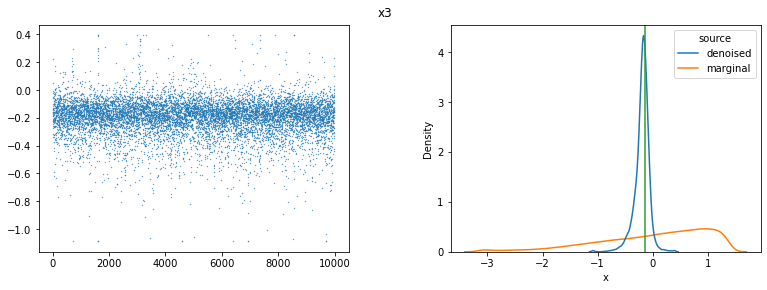

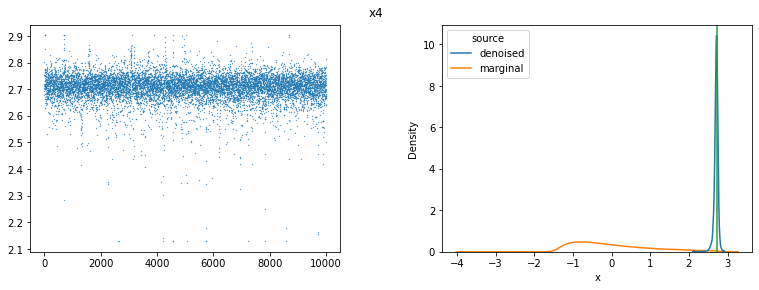

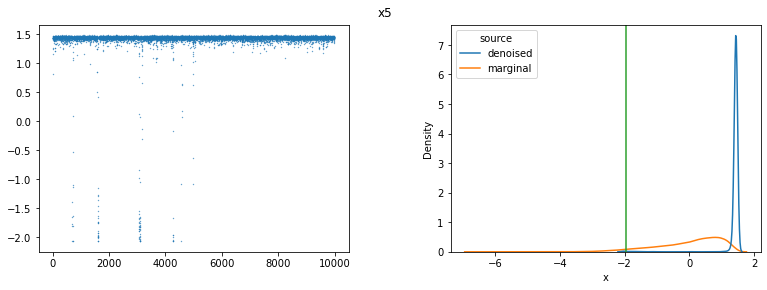

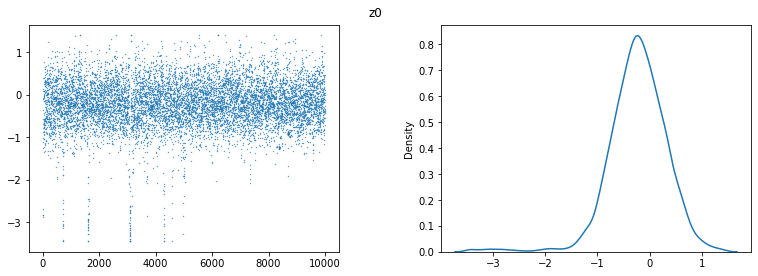

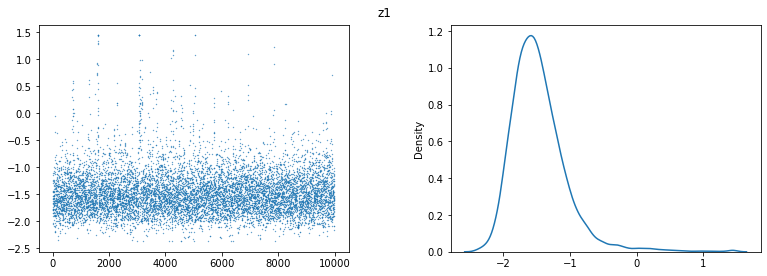

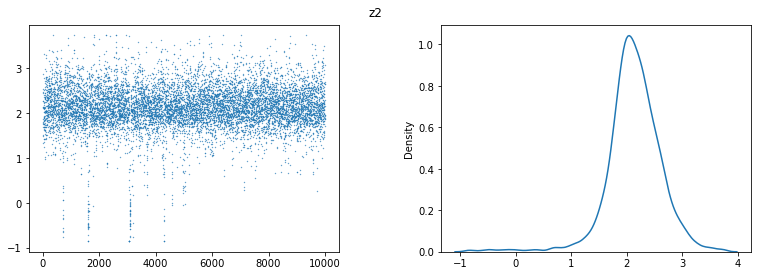

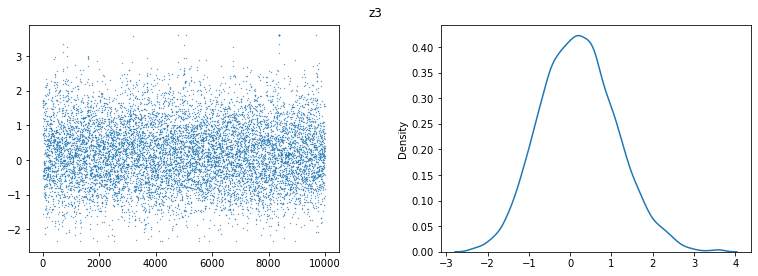

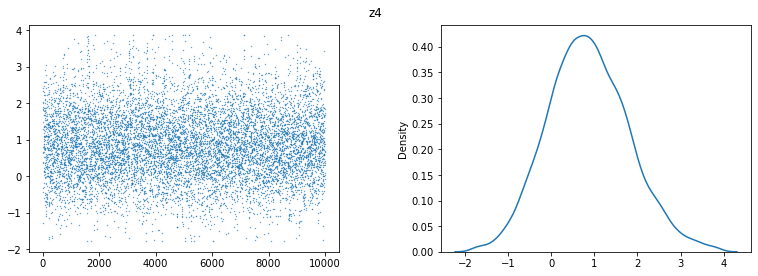

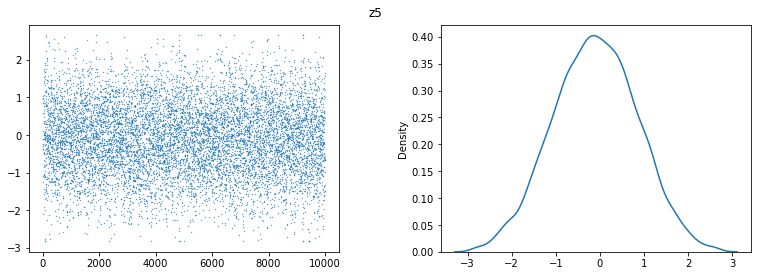

In [65]:
import pandas as pd

for sample_name, sample in mcmc.get_samples().items():
    sample = onp.array(sample)
    if sample.ndim == 1:
        sample = onp.expand_dims(sample, axis=1)  # to avoid iterating over items
    for i, col in enumerate(onp.transpose(sample)):
        col = onp.clip(col, jnp.quantile(col, 0.001), jnp.quantile(col, 0.999))
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.tight_layout(pad=2.0)
        fig.set_size_inches(12, 4)
        fig.suptitle(sample_name + str(i))
        ax1.scatter(range(len(col)), col, s=0.1)

        if sample_name == "x":
            # Plot p(s) too
            df = pd.DataFrame({
                "x": onp.concatenate((col, s[:, i])),
                "source": onp.repeat(["denoised", "marginal"], [len(col), len(s[:, i])])
            })

            sns.kdeplot(data=df, x="x", hue="source", ax=ax2, common_norm=False)
            ax2.axvline(y_obs[i].item(), color="tab:green")

        else:
            sns.kdeplot(col)
        plt.show()



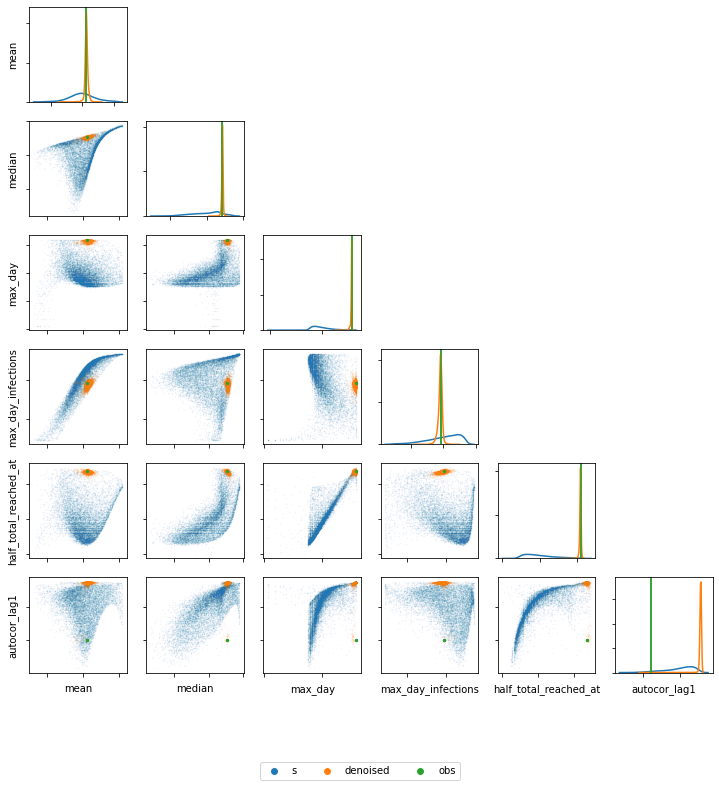

In [182]:
denoised = mcmc.get_samples()["x"]
pairplot((s, denoised), y_obs, col_names=s_names, names=["s", "denoised", "obs"])

### Posterior inference

In [94]:
key, flow_key, train_key = random.split(key, 3)

posterior_flow = NeuralSplineFlow(
    flow_key,
    target_dim=theta.shape[1],
    condition_dim=s.shape[1])

posterior_flow, losses = train_flow(train_key, posterior_flow, theta, s, max_epochs=30)


 70%|███████   | 21/30 [01:17<00:33,  3.68s/it, train=-6.72, val=-6.62]

Max patience reached.


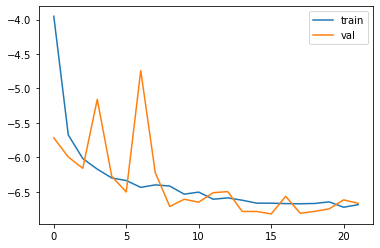

In [95]:
for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend()

### Sample non-robust and robust posterior

In [96]:
robust_condition = mcmc.get_samples()["x"]
n_samples = robust_condition.shape[0]
non_robust_condition = jnp.repeat(jnp.expand_dims(y_obs, 0), n_samples, axis=0)
well_specified_condition = jnp.repeat(jnp.expand_dims(s[obs_num], 0), n_samples, axis=0)


In [147]:
keys = random.split(key, 4)
key, sample_keys = keys[0], keys[1:]

conditions = {
    "robust": robust_condition,
    "non_robust": non_robust_condition
}

posteriors = {"prior": theta[:n_samples]}

for key, (name, condition) in zip(sample_keys, conditions.items()):
    samps = posterior_flow.sample(key, n_samples, condition)
    posteriors[name] = onp.array(samps)
    

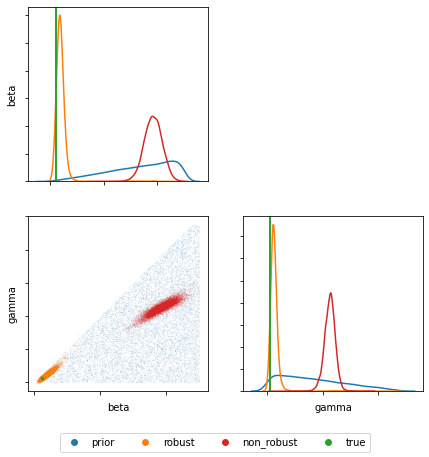

In [186]:
names = list(posteriors.keys())
names.append("true")
pairplot(posteriors.values(), theta_true, col_names = ["beta", "gamma"], names=names)